In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/burnout-datathon-ieeecsmuj/sample_submission.csv
/kaggle/input/burnout-datathon-ieeecsmuj/val.csv
/kaggle/input/burnout-datathon-ieeecsmuj/train.csv
/kaggle/input/burnout-datathon-ieeecsmuj/test.csv


# Imports

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import xgboost as xgb
from catboost import CatBoostRegressor
import lightgbm as lgb
import os
import joblib

# Data Loading

In [4]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

train_df = pd.read_csv('/kaggle/input/burnout-datathon-ieeecsmuj/train.csv')
test_df = pd.read_csv('/kaggle/input/burnout-datathon-ieeecsmuj/test.csv')
val_df = pd.read_csv('/kaggle/input/burnout-datathon-ieeecsmuj/val.csv')

print("Training set shape:", train_df.shape)
print("Test set shape:", test_df.shape)
print("Validation set shape:", val_df.shape)

print("\nTraining set info:")
train_df.info()
print("\nFirst few rows of training set:")
train_df.head()

/kaggle/input/burnout-datathon-ieeecsmuj/sample_submission.csv
/kaggle/input/burnout-datathon-ieeecsmuj/val.csv
/kaggle/input/burnout-datathon-ieeecsmuj/train.csv
/kaggle/input/burnout-datathon-ieeecsmuj/test.csv
Training set shape: (1914056, 45)
Test set shape: (546874, 44)
Validation set shape: (273437, 45)

Training set info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1914056 entries, 0 to 1914055
Data columns (total 45 columns):
 #   Column                           Dtype  
---  ------                           -----  
 0   Unique ID                        int64  
 1   Rider_ID                         int64  
 2   category_x                       object 
 3   Circuit_Length_km                float64
 4   Laps                             int64  
 5   Grid_Position                    int64  
 6   Avg_Speed_kmh                    float64
 7   Track_Condition                  object 
 8   Humidity_%                       int64  
 9   Tire_Compound_Front              object 
 10 

,Unique ID,Rider_ID,category_x,Circuit_Length_km,Laps,Grid_Position,Avg_Speed_kmh,Track_Condition,Humidity_%,Tire_Compound_Front,...,air,ground,starts,finishes,with_points,podiums,wins,min_year,max_year,years_active
0,1894944,2659,Moto2,4.874,22,17,264.66,Wet,61,Hard,...,23,35,53,45,41,4,0,2018,2021,4
1,23438,5205,Moto2,3.875,24,7,177.56,Wet,77,Soft,...,12,12,27,27,22,2,1,1975,1983,8
2,939678,7392,Moto3,5.647,25,5,317.74,Dry,87,Soft,...,22,23,45,43,10,0,0,1982,1989,8
3,1196312,7894,Moto3,4.810,19,3,321.82,Wet,43,Soft,...,23,35,192,172,155,16,9,1994,2009,16
4,1033899,6163,MotoGP,5.809,25,21,239.92,Wet,47,Hard,...,22,31,175,146,132,29,17,2011,2021,11


# Exploratory Data Analysis

## Target Variable Analysis


--- Target Variable Analysis ---


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


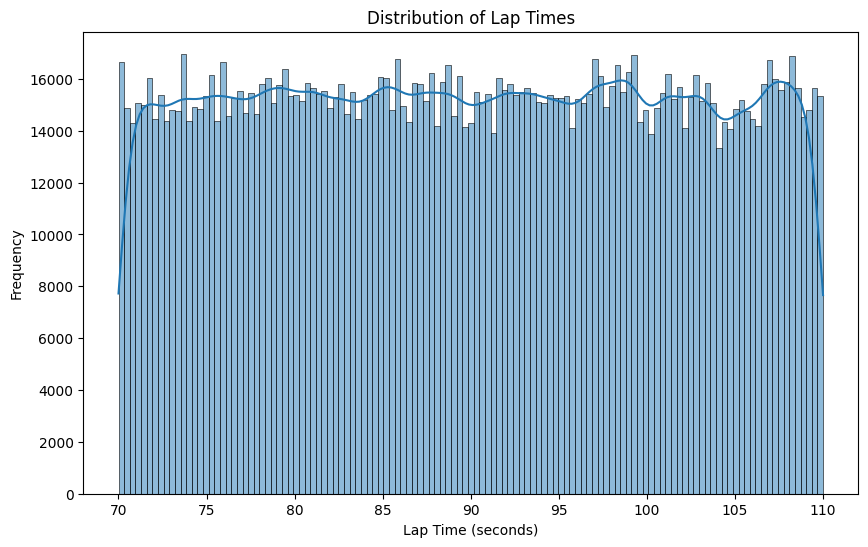

Number of outliers in lap times (IQR method): 0


In [7]:
print("\n--- Target Variable Analysis ---")
plt.figure(figsize=(10, 6))
sns.histplot(train_df['Lap_Time_Seconds'], kde=True)
plt.title('Distribution of Lap Times')
plt.xlabel('Lap Time (seconds)')
plt.ylabel('Frequency')
plt.show()

q1 = train_df['Lap_Time_Seconds'].quantile(0.25)
q3 = train_df['Lap_Time_Seconds'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
outliers = train_df[(train_df['Lap_Time_Seconds'] < lower_bound) | (train_df['Lap_Time_Seconds'] > upper_bound)]
print(f"Number of outliers in lap times (IQR method): {len(outliers)}")

## Categorical Features Analysis


--- Categorical Features Analysis ---


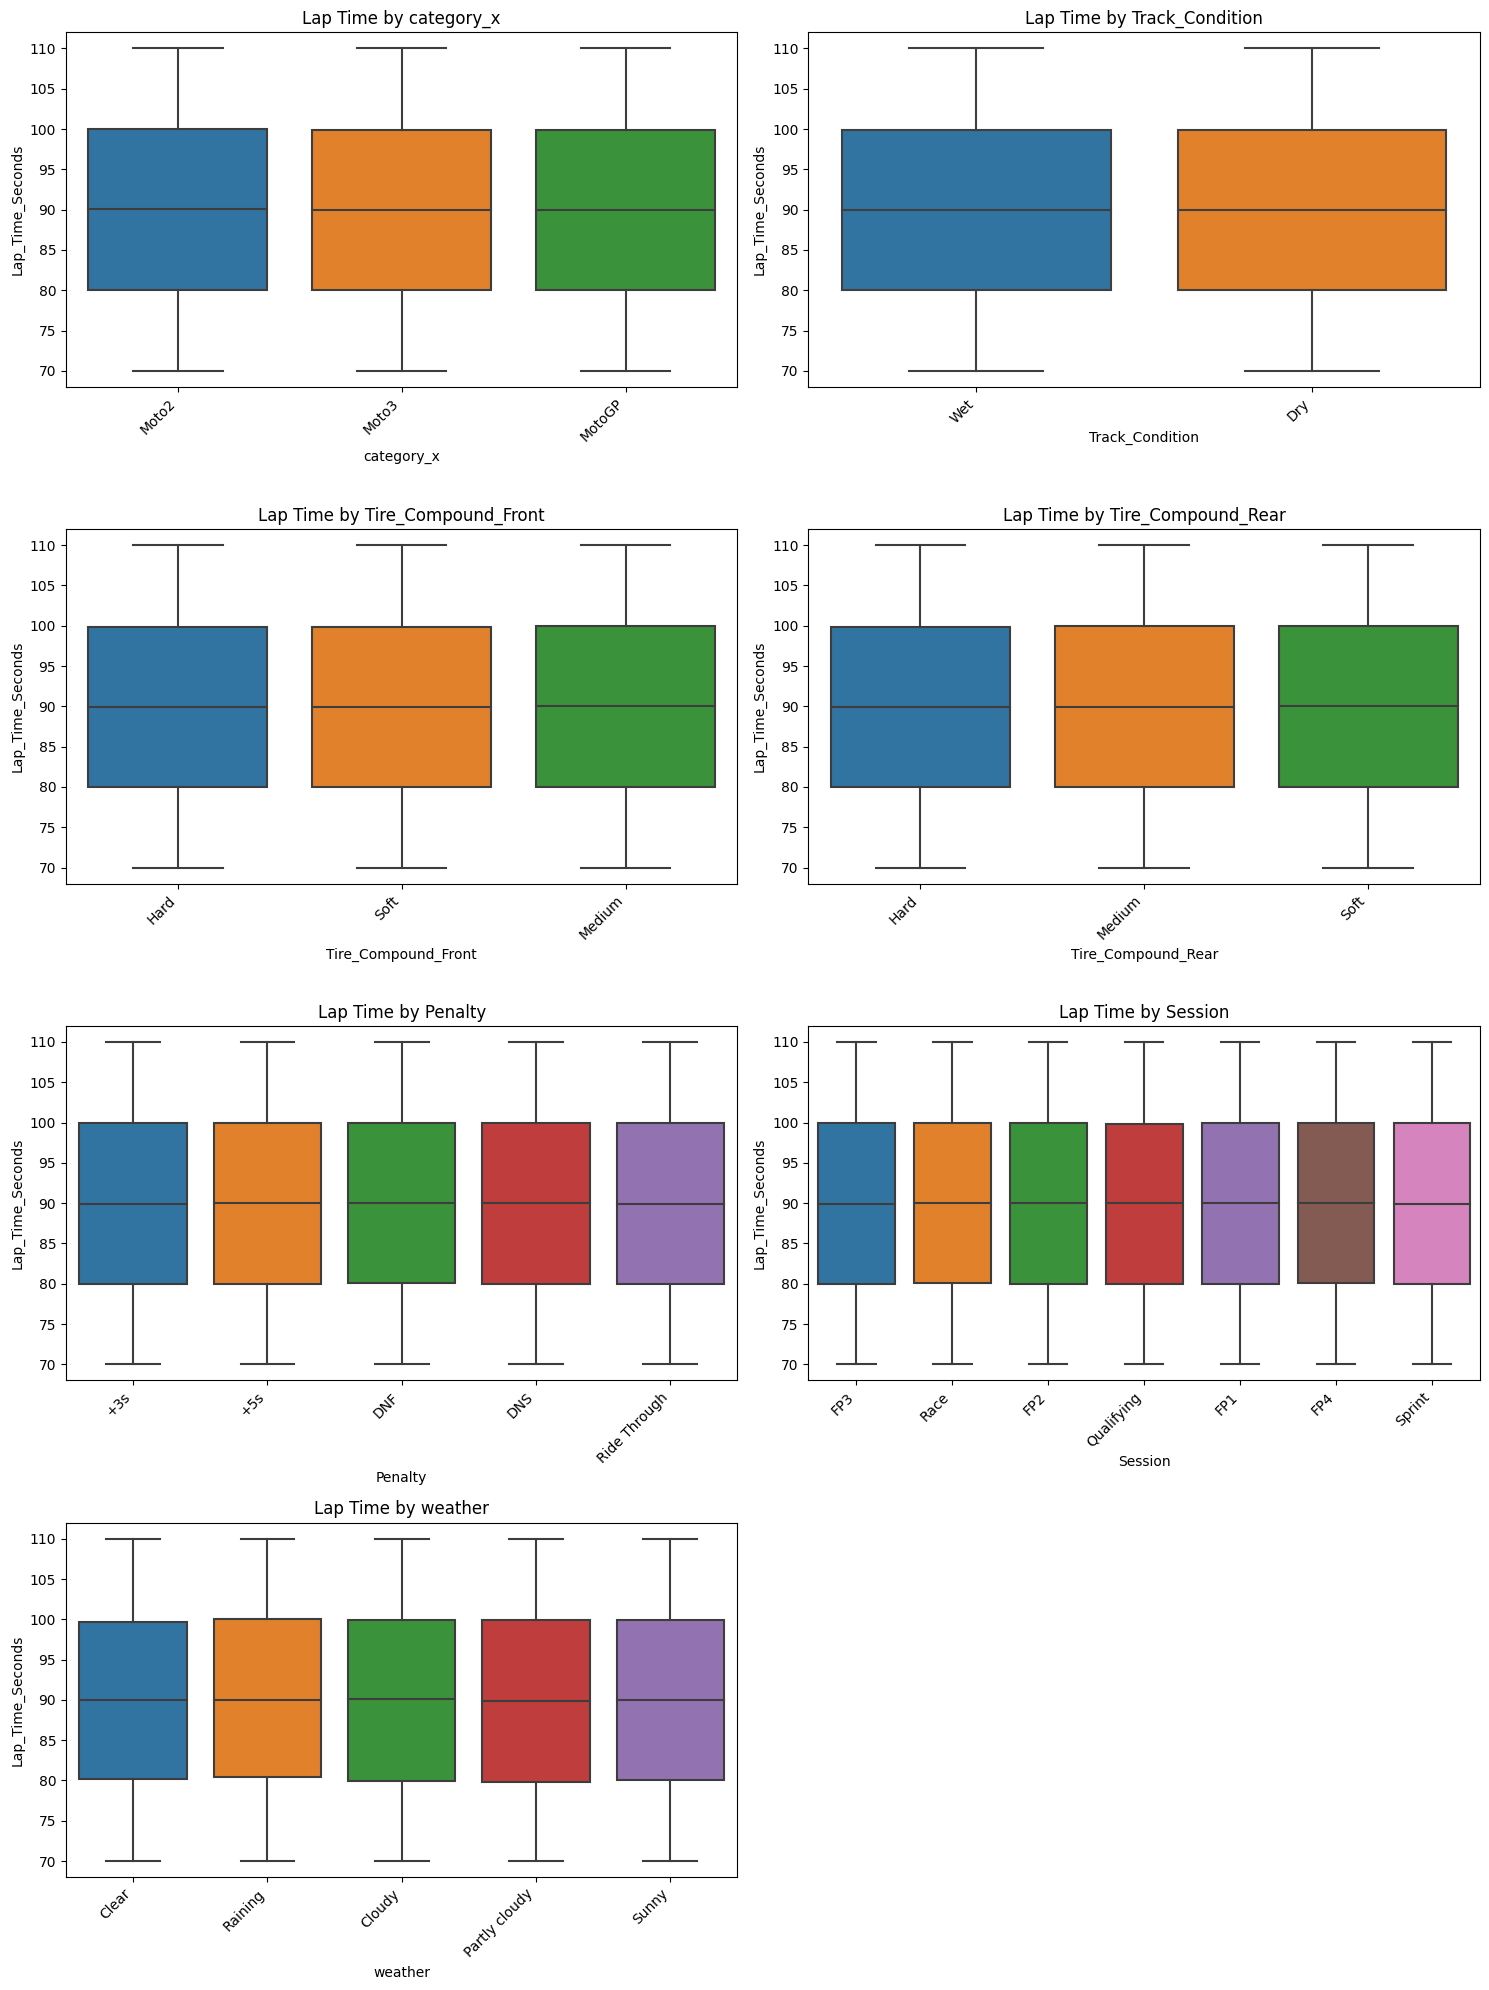

In [8]:
print("\n--- Categorical Features Analysis ---")
cat_cols = ['category_x', 'Track_Condition', 'Tire_Compound_Front', 'Tire_Compound_Rear',
            'Penalty', 'Session', 'weather']

plt.figure(figsize=(15, 20))
for i, col in enumerate(cat_cols, 1):
    plt.subplot(4, 2, i)
    sns.boxplot(x=col, y='Lap_Time_Seconds', data=train_df)
    plt.xticks(rotation=45, ha='right')
    plt.title(f'Lap Time by {col}')
plt.tight_layout()
plt.show()

## Numerical Features Analysis


--- Numerical Features Analysis ---


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


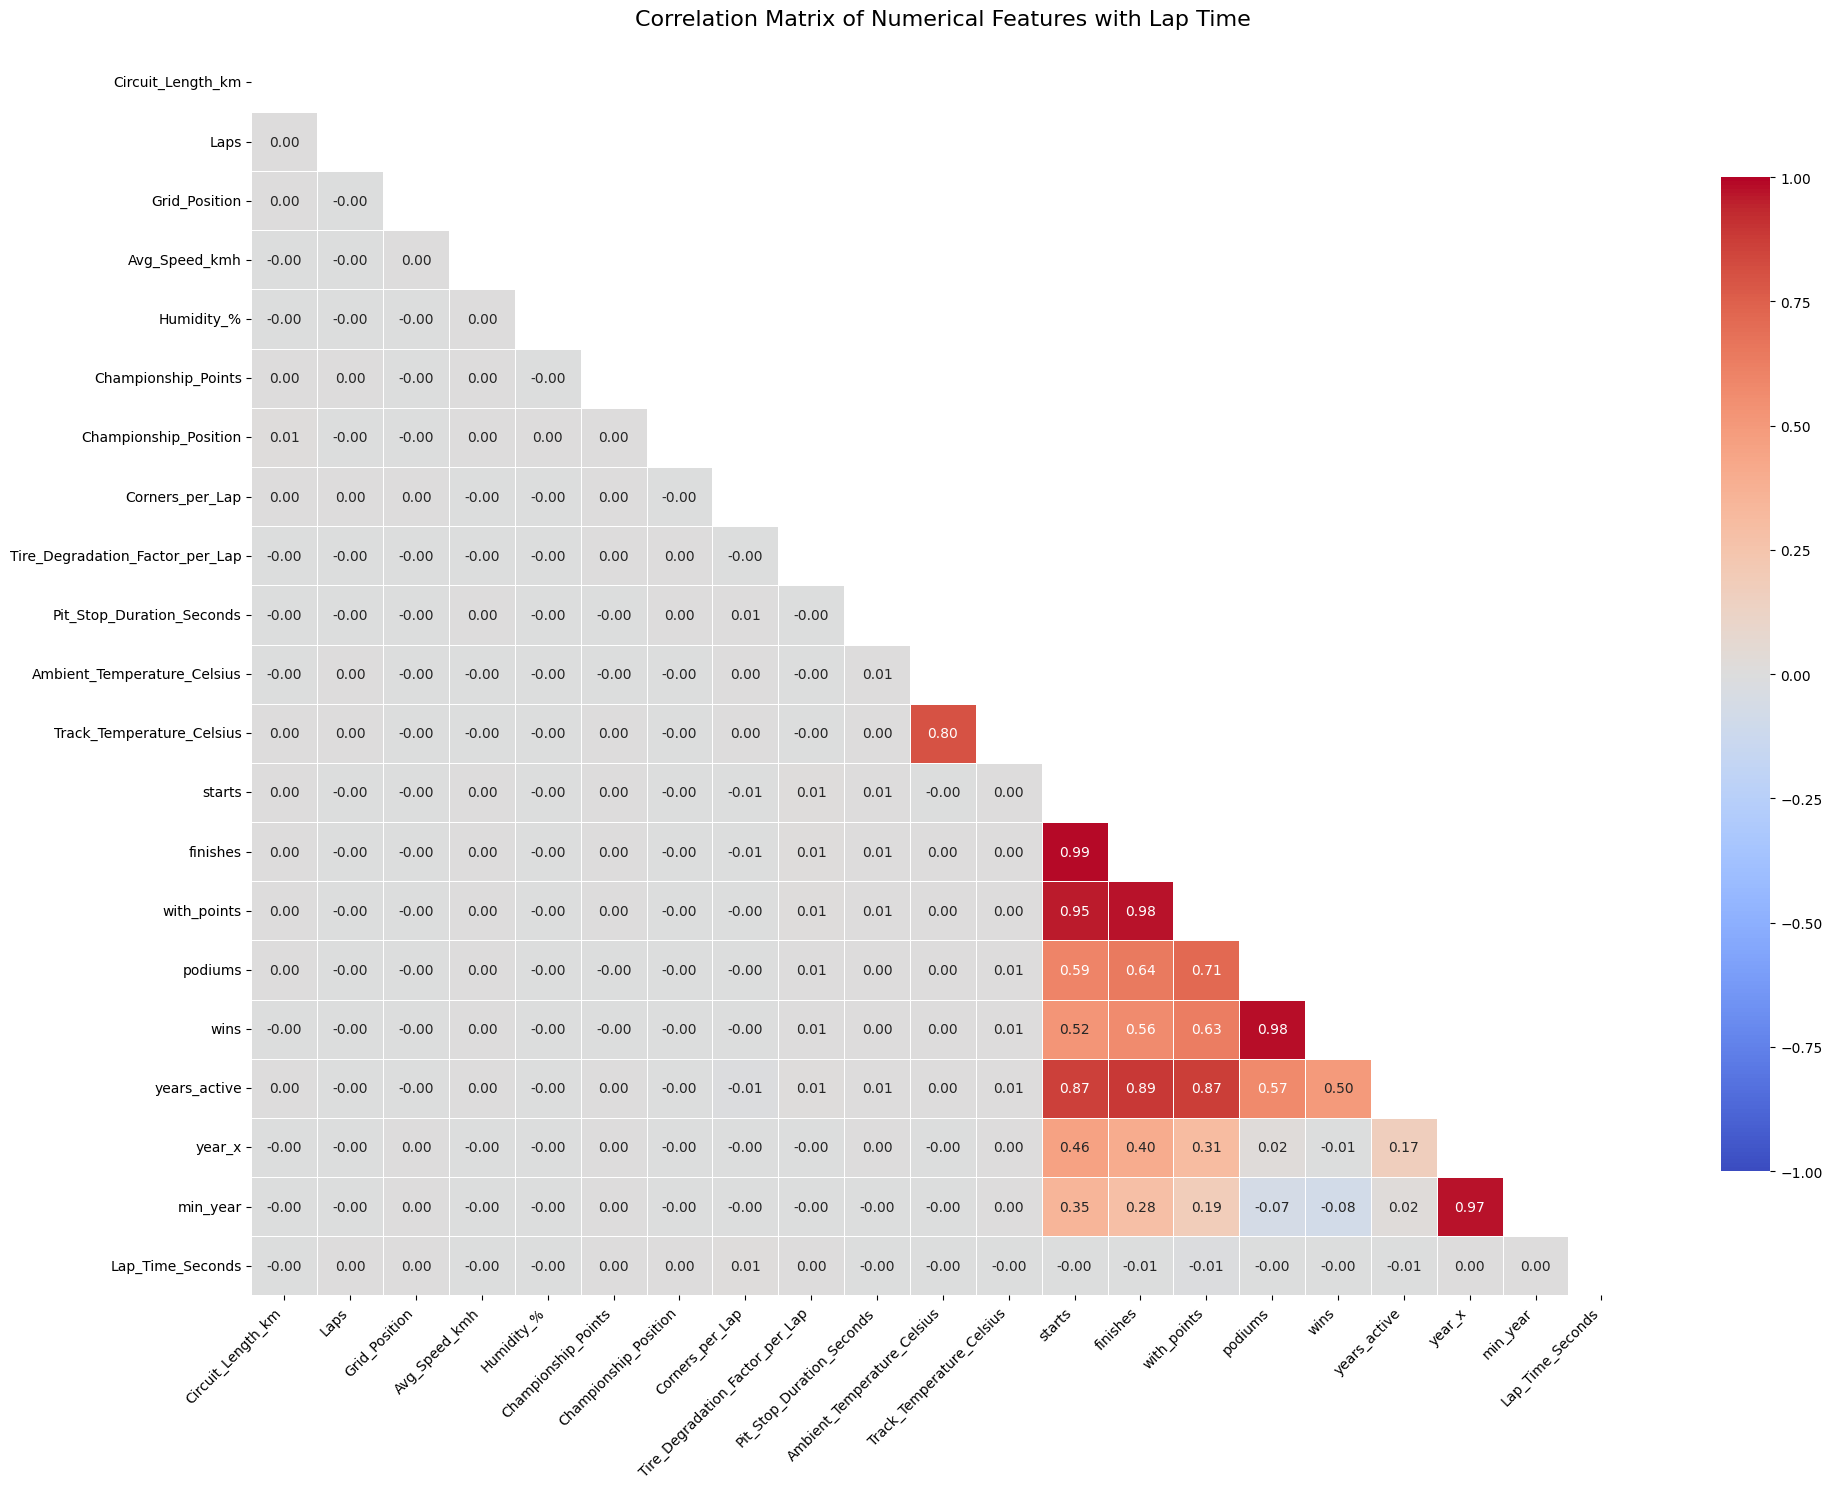


Top Positive Correlations with Lap Time:
Lap_Time_Seconds                   1.000000
Corners_per_Lap                    0.008514
min_year                           0.003543
year_x                             0.001710
Championship_Points                0.000837
Grid_Position                      0.000746
Tire_Degradation_Factor_per_Lap    0.000676
Championship_Position              0.000641
Laps                               0.000614
Humidity_%                        -0.000018
Name: Lap_Time_Seconds, dtype: float64

Top Negative Correlations with Lap Time:
Circuit_Length_km             -0.000837
Pit_Stop_Duration_Seconds     -0.001746
wins                          -0.003585
Ambient_Temperature_Celsius   -0.004110
podiums                       -0.004194
Track_Temperature_Celsius     -0.004662
starts                        -0.004771
finishes                      -0.006135
years_active                  -0.007236
with_points                   -0.008157
Name: Lap_Time_Seconds, dtype: float6

In [9]:
print("\n--- Numerical Features Analysis ---")
num_cols = [
    'Circuit_Length_km', 'Laps', 'Grid_Position', 'Avg_Speed_kmh', 'Humidity_%',
    'Championship_Points', 'Championship_Position', 'Corners_per_Lap',
    'Tire_Degradation_Factor_per_Lap', 'Pit_Stop_Duration_Seconds',
    'Ambient_Temperature_Celsius', 'Track_Temperature_Celsius',
    'starts', 'finishes', 'with_points', 'podiums', 'wins', 'years_active', 'year_x', 'min_year'
]

existing_num_cols = [col for col in num_cols if col in train_df.columns]
corr_data = train_df[existing_num_cols + ['Lap_Time_Seconds']].replace([np.inf, -np.inf], np.nan).dropna()
corr_matrix = corr_data.corr()

plt.figure(figsize=(20, 15))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f",
            cmap='coolwarm', center=0, vmin=-1, vmax=1,
            linewidths=0.5, linecolor='white', cbar_kws={"shrink": .8})
plt.title('Correlation Matrix of Numerical Features with Lap Time', pad=20, fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

if 'Lap_Time_Seconds' in corr_matrix.columns:
    lap_time_corr = corr_matrix['Lap_Time_Seconds'].sort_values(ascending=False)
    print("\nTop Positive Correlations with Lap Time:")
    print(lap_time_corr.head(10))
    print("\nTop Negative Correlations with Lap Time:")
    print(lap_time_corr.tail(10))
else:
    print("\n'Lap_Time_Seconds' not found in correlation matrix (perhaps only one row in corr_data).")

## Time-Based Analysis


--- Time-Based Analysis ---


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


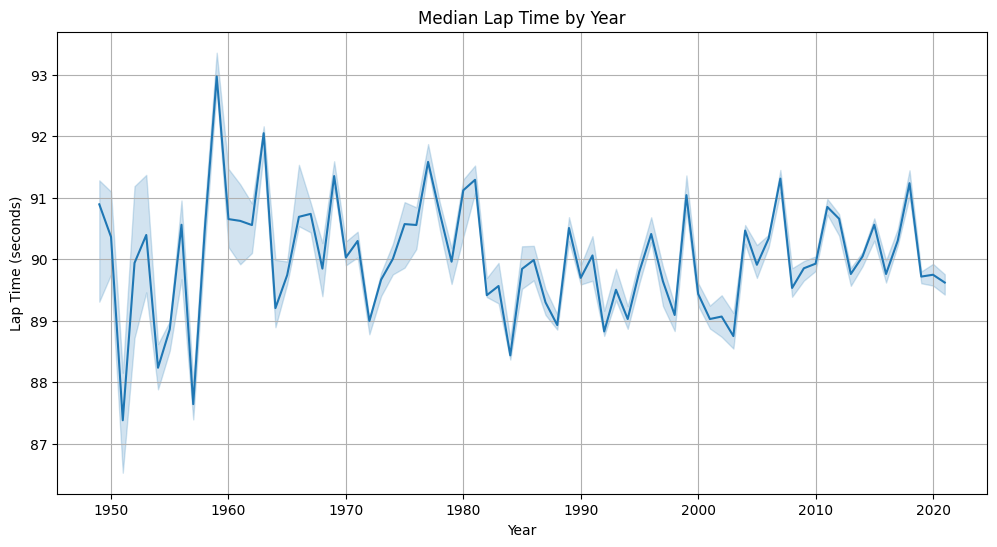

In [10]:
print("\n--- Time-Based Analysis ---")
plt.figure(figsize=(12, 6))
train_df['Lap_Time_Seconds'] = train_df['Lap_Time_Seconds'].replace([float('inf'), float('-inf')], np.nan)
train_df['year_x'] = train_df['year_x'].replace([float('inf'), float('-inf')], np.nan)
sns.lineplot(x='year_x', y='Lap_Time_Seconds', data=train_df, estimator='median')
plt.title('Median Lap Time by Year')
plt.xlabel('Year')
plt.ylabel('Lap Time (seconds)')
plt.grid(True)
plt.show()

# Data Preprocessing and Feature Engineering 

## Handling Missing Values

In [11]:
print("\n--- Handling Missing Values ---")
train_df['Penalty'] = train_df['Penalty'].fillna('No Penalty')
test_df['Penalty'] = test_df['Penalty'].fillna('No Penalty')
val_df['Penalty'] = val_df['Penalty'].fillna('No Penalty')

print("Missing values in training set after initial imputation:")
print(train_df.isnull().sum().sort_values(ascending=False))


--- Handling Missing Values ---
Missing values in training set after initial imputation:
Unique ID                          0
Rider_ID                           0
category_x                         0
Circuit_Length_km                  0
Laps                               0
Grid_Position                      0
Avg_Speed_kmh                      0
Track_Condition                    0
Humidity_%                         0
Tire_Compound_Front                0
Tire_Compound_Rear                 0
Penalty                            0
Championship_Points                0
Championship_Position              0
Session                            0
year_x                             0
sequence                           0
rider                              0
team                               0
bike                               0
position                           0
points                             0
shortname                          0
circuit_name                       0
rider_name            

## Feature Engineering

In [12]:
print("\n--- Feature Engineering ---")

global_min_year = pd.concat([train_df['year_x'], test_df['year_x'], val_df['year_x']]).min()

def engineer_features(df, global_min_year_val):
    df['starts_safe'] = df['starts'].replace(0, np.nan)

    df['Experience'] = df['years_active'] / (df['year_x'] - global_min_year_val + 1).replace(0, np.nan)
    df['Finish_Rate'] = df['finishes'] / df['starts_safe']
    df['Podium_Rate'] = df['podiums'] / df['starts_safe']
    df['Win_Rate'] = df['wins'] / df['starts_safe']
    df['Points_Rate'] = df['with_points'] / df['starts_safe']

    df['Speed_to_Circuit_Ratio'] = df['Avg_Speed_kmh'] / df['Circuit_Length_km'].replace(0, np.nan)

    df['Tire_Impact'] = df['Tire_Degradation_Factor_per_Lap'] * df['Laps']

    df['Position_Potential'] = df['Grid_Position'] - df['Championship_Position']

    df['Weather_Impact'] = np.where(df['weather'] == 'rainy', 1, 0)
    df['Track_Condition_Impact'] = np.where(df['Track_Condition'] == 'wet', 1, 0)

    df = df.drop(columns=['starts_safe'], errors='ignore')
    df = df.replace([np.inf, -np.inf], np.nan)

    return df

train_df = engineer_features(train_df, global_min_year)
test_df = engineer_features(test_df, global_min_year)
val_df = engineer_features(val_df, global_min_year)

selected_features = [
    'Circuit_Length_km', 'Laps', 'Grid_Position', 'Avg_Speed_kmh',
    'Humidity_%', 'Championship_Points', 'Championship_Position',
    'Corners_per_Lap', 'Tire_Degradation_Factor_per_Lap',
    'Ambient_Temperature_Celsius', 'Track_Temperature_Celsius',
    'Pit_Stop_Duration_Seconds',
    'Experience', 'Finish_Rate', 'Podium_Rate', 'Win_Rate',
    'Points_Rate', 'Speed_to_Circuit_Ratio', 'Tire_Impact',
    'Position_Potential', 'Weather_Impact', 'Track_Condition_Impact',
    'category_x', 'Track_Condition', 'Tire_Compound_Front',
    'Tire_Compound_Rear', 'Session', 'weather'
]

target = 'Lap_Time_Seconds'


--- Feature Engineering ---


# Model Development 

## Preprocessing Pipeline

In [13]:
X_train = train_df[selected_features]
y_train = train_df[target]
X_val = val_df[selected_features]
y_val = val_df[target]

numeric_features = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_features = X_train.select_dtypes(include='object').columns.tolist()

print(f"\nNumeric features for preprocessing: {numeric_features}")
print(f"Categorical features for preprocessing: {categorical_features}")

if not (set(numeric_features) | set(categorical_features) == set(selected_features)):
    uncovered_features = set(selected_features) - (set(numeric_features) | set(categorical_features))
    print(f"Warning: Some selected features are not recognized as numeric or categorical: {uncovered_features}")

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])


Numeric features for preprocessing: ['Circuit_Length_km', 'Laps', 'Grid_Position', 'Avg_Speed_kmh', 'Humidity_%', 'Championship_Points', 'Championship_Position', 'Corners_per_Lap', 'Tire_Degradation_Factor_per_Lap', 'Ambient_Temperature_Celsius', 'Track_Temperature_Celsius', 'Pit_Stop_Duration_Seconds', 'Experience', 'Finish_Rate', 'Podium_Rate', 'Win_Rate', 'Points_Rate', 'Speed_to_Circuit_Ratio', 'Tire_Impact', 'Position_Potential', 'Weather_Impact', 'Track_Condition_Impact']
Categorical features for preprocessing: ['category_x', 'Track_Condition', 'Tire_Compound_Front', 'Tire_Compound_Rear', 'Session', 'weather']


## Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import cross_val_score
import optuna
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 10, 20),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 0.5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
        'random_state': 42,
        'tree_method': 'hist',
        'device': 'cuda'
    }
    
    model = xgb.XGBRegressor(**params)
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    scores = cross_val_score(pipeline, X_train, y_train, 
                           cv=5, scoring='neg_root_mean_squared_error')
    return -scores.mean()

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20,n_jobs=-1)

print("Best trial:")
trial = study.best_trial
print(f"RMSE: {trial.value:.4f}")
print("Best params:")
print(trial.params)

In [14]:
print("\n--- Model Training, Saving, and Evaluation ---")

models = {
    'XGBoost': xgb.XGBRegressor(n_estimators=433, max_depth=18, learning_rate= 0.2550333930882739, subsample=0.8332531303240234, colsample_bytree=0.9992660783644403, min_child_weight=4, gamma=0.004522254153302818,reg_alpha=0.2355599512208678,reg_lambda=0.5449468735593271),
}

results = {}
for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)])

    print(f"Training {name}...")
    pipeline.fit(X_train, y_train)

    model_filename = f'{name.lower()}_pipeline.joblib'
    joblib.dump(pipeline, model_filename)
    print(f"Saved {name} pipeline to {model_filename}")

    y_pred = pipeline.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    results[name] = rmse
    print(f"{name} RMSE: {rmse:.4f}\n")


best_model_name = min(results, key=results.get)
best_rmse = results[best_model_name]

print(f"\nAutomatically selected '{best_model_name}' as the final model due to lowest RMSE: {best_rmse:.4f}")

print(f"\nLoading {best_model_name} as the final model for predictions...")
final_model_filename = f'{best_model_name.lower()}_pipeline.joblib'
final_model = joblib.load(final_model_filename)
print(f"Successfully loaded {best_model_name} from {final_model_filename}")

X_test = test_df[selected_features]
test_predictions = final_model.predict(X_test)

submission = pd.DataFrame({
    'Unique ID': test_df['Unique ID'],
    'Lap_Time_Seconds': test_predictions
})

submission.to_csv('solution.csv', index=False)
print("\nSubmission file created successfully!")
print(submission.head())


--- Model Training, Saving, and Evaluation ---
Training XGBoost...
Saved XGBoost pipeline to xgboost_pipeline.joblib
XGBoost RMSE: 0.0416


Automatically selected 'XGBoost' as the final model due to lowest RMSE: 0.0416

Loading XGBoost as the final model for predictions...
Successfully loaded XGBoost from xgboost_pipeline.joblib

Submission file created successfully!
   Unique ID  Lap_Time_Seconds
0     288307         89.930710
1     704288        104.073395
2     951491         86.256393
3    2591721        109.779160
4    1202653         99.320763
